In [4]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', 500)

# Data

In [97]:
df = pd.read_csv('../data/processed/final_dataset_v2.csv')

In [98]:
df.head(1)

,main_name,location,id,property_type,price_type,days_on_site,lat,lon,Baños,Estacionamientos,Recámaras,m2_totales,m2_construidos,years,price_final,source,geometry,index_right,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,Ambito,new_id,num_comercios,is_consultorio,is_recreativo,is_retail,is_escuela,Baños_imp,Recámaras_imp,num_comercios_imp,is_consultorio_imp,is_recreativo_imp,is_retail_imp,is_escuela_imp,precio_m2,precio_m2_final
0,renta departamento en roma norte,"Av Chapultepec 322, Roma Norte, Ciudad De Méxi...",1,depto,renta,6.0,19.422992,-99.164232,2.0,1.0,2.0,85.0,85.0,1.0,17500.0,metros_cubicos,POINT (-99.1642322 19.4229918),12624,0901500010998,9,15,1,0998,Urbana,1,605.0,17.0,106.0,256.0,12.0,2.0,2.0,605.0,17.0,106.0,256.0,12.0,35294.117647,35294.117647


In [99]:
df = df[[#'property_type', 
         'price_type','lat', 'lon', 
         'years', 
         'CVEGEO', 'new_id', 
         'num_comercios_imp', 'is_consultorio_imp',
         'is_recreativo_imp', 'is_retail_imp', 'is_escuela_imp', 
    #'is_depto', 
         'Baños_imp',
         'Recámaras_imp',  'precio_m2_final']]

In [100]:
#Explorar años
df[['years', 'precio_m2_final']].corr()

,years,precio_m2_final
years,1.000000,-0.050947
precio_m2_final,-0.050947,1.000000


In [101]:
# variable de ageb
ageb_stats = df.groupby('CVEGEO').agg({'precio_m2_final':'describe',
                                         
                                        }).reset_index()

In [102]:
ageb_stats.columns = ageb_stats.columns.map('_'.join).str.strip('_')

In [103]:
ageb_stats.head(1)

,CVEGEO,precio_m2_final_count,precio_m2_final_mean,precio_m2_final_std,precio_m2_final_min,precio_m2_final_25%,precio_m2_final_50%,precio_m2_final_75%,precio_m2_final_max
0,0900300011410,1.0,57000.0,NaN,57000.0,57000.0,57000.0,57000.0,57000.0


In [104]:
ageb_stats = ageb_stats[['CVEGEO', 'precio_m2_final_25%',
                         'precio_m2_final_50%', 'precio_m2_final_75%'
                        ]]

In [105]:
ageb_stats = ageb_stats.rename(columns={'precio_m2_final_25%':'ageb_precio_m2_25_pct',
                                        'precio_m2_final_50%':'ageb_precio_m2_50_pct',
                                        'precio_m2_final_75%':'ageb_precio_m2_75_pct',
                                       })

In [106]:
ageb_stats.to_csv('../data/features/ageb_stats.csv', index=False)

In [107]:
# Puntos cercanos por lat lon

In [108]:
ids = df.new_id.unique().tolist()

In [109]:
import geopy.distance as dist

In [141]:
%%time
for id_ in ids:
    reference = df[df.new_id==id_]
    temp = df[df.new_id!=id_]
    temp = temp.copy()
    
    coords_1 = (reference.lat.values[0], reference.lon.values[0])
    parque = (19.412308, -99.169403)
    fuente = (19.4190192,-99.164285)
    
    temp['coord_tuple'] = list(zip(temp.lat, temp.lon))
    distances = []
    for i in temp['coord_tuple']:
        distance = dist.distance(coords_1, i).km * 1000
        distances.append(distance)
        
    temp['distance'] = distances
    temp = temp.sort_values('distance')
    temp = temp.head(10)
    
    df.loc[df.new_id==id_, 'nearest_50_pct_price'] = temp.precio_m2_final.median()
    df.loc[df.new_id==id_, 'nearest_75_pct_price'] = temp.precio_m2_final.quantile(.75)
    df.loc[df.new_id==id_, 'nearest_25_pct_price'] = temp.precio_m2_final.quantile(.25)
    df.loc[df.new_id==id_, 'nearest_std_price'] = temp.precio_m2_final.std()
    
    df.loc[df.new_id==id_, 'distance_parque'] = dist.distance(coords_1, parque).km * 1000
    df.loc[df.new_id==id_, 'distance_fuente'] = dist.distance(coords_1, fuente).km * 1000

CPU times: user 3min 9s, sys: 548 ms, total: 3min 9s
Wall time: 3min 10s


In [142]:
# Unir con precio por ageb

In [143]:
len(df)

1316

In [144]:
feature_set = df.merge(ageb_stats, how='left', on='CVEGEO')

In [145]:
len(feature_set)

1316

In [146]:
feature_set.to_csv('../data/features/feature_set_v2.csv', index=False)

In [151]:
import seaborn as sns
import matplotlib.pyplot as plt

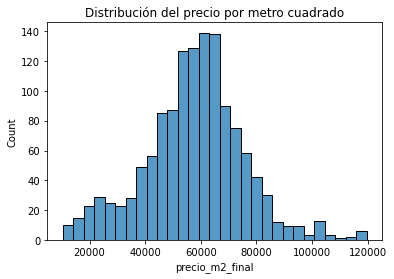

In [152]:
ax = sns.histplot(feature_set.precio_m2_final)
plt.title('Distribución del precio por metro cuadrado')
plt.show()